In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import vuong_plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
beta0 = 1.
beta1 = .25

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


yn,xn,nobs = gen_data()
print(xn.shape)
print(sm.add_constant(xn).shape)
print(scipy.stats.mode(yn))

(1000,)
(1000, 2)
ModeResult(mode=array([0.]), count=array([86]))


In [8]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(Tobit,self).__init__(*args,**kwargs)
        self.ols = ols

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params
        
        mu_y = np.matmul(x,beta)
        
        pr_y = stats.norm.logpdf( y, loc = mu_y)
        
       
        #if complete case, assign pr missing to all observations...
        pr_m = stats.norm.logcdf( y, loc = mu_y)
        
        #we're done if ols
        if self.ols:
            return pr_y
        else:
            ll = (1-m)*pr_y + m*pr_m
            return ll
        
    def score(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        m_x = np.repeat(m,x.shape[1]).reshape(x.shape)
        
        if ols: #if OLS use all the data...
            m, m_x = np.ones(y.shape), np.ones(x.shape)
        
        
        b = params

        beta_jac = np.zeros(len(b))
        
        #for censored
        if not cc and not ols: 
            left_stats = (y - np.dot(x, b)) 
            l_pdf = scipy.stats.norm.logpdf(left_stats)
            l_cdf = scipy.stats.norm.logcdf(left_stats)
            left_frac = np.exp(l_pdf - l_cdf)
            beta_left = np.dot(left_frac*m, x*m_x)
            beta_jac -= beta_left
        
        #for non-censored
        mid_stats = (y - np.dot(x, b))
        beta_mid = np.dot(mid_stats*(1-m), x*(1-m_x) )
        beta_jac += beta_mid
        
        # by chain rule, since the expression above is dloglik/dlogsigma
        return beta_jac



model1 =  Tobit(yn,sm.add_constant(xn))
model1_fit = model1.fit(disp=False)
print(model1_fit.summary())

model2 =  Tobit(yn,sm.add_constant(xn),ols=True)
model2_fit = model2.fit(disp=False)
print(model2_fit.summary())

                                Tobit Results                                 
Dep. Variable:                      y   Log-Likelihood:                -1410.3
Model:                          Tobit   AIC:                             2825.
Method:            Maximum Likelihood   BIC:                             2834.
Date:                Mon, 22 Mar 2021                                         
Time:                        20:07:00                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0031      0.046     21.870      0.000       0.913       1.093
x1             0.2465      0.006     38.442      0.0

In [9]:
def setup_shi(yn,xn):
    model1 = Tobit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)
    k1 = len(model1_fit.params)
    
    #fit logistic values
    model2 = Tobit(yn,sm.add_constant(xn),ols=True)
    model2_fit = model2.fit(disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    k2 = len(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,k1, grad2,hess2,k2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

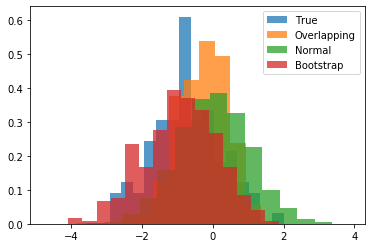

In [13]:
beta0 = 1.
beta1 = .25

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 500
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi,trials=100)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_pt(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.savefig('../figs/tobit_plot25.png')
plt.show()

In [14]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean() - np.array(bootstrap_stats).mean()
print(thing1)
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()
print(thing2)
print(thing1/thing2)

1 --------
0.0 -0.7074907263979345
0.0 -0.27190103932981624
0.0 0.03173043165361531
0.0 -0.9258083314945914
---------
2 --------
0.9377167509376504 0.9471886373107585
0.4624377674570971 0.4625302735117995
0.9969311304150807 0.997130556526386
1.0786886790811305 1.082296333526218
---------
3 --------
0.042814567403794045 0.04412963038939786
-0.08906687571696814 -0.08912034079181591
0.04356284334542006 0.04358899325425304
-0.16328374219762204 -0.1649293708085779
---------
4 --------
2.550198759054294 -0.03810245009816984
0.708194818446114 0.06699906971824036
2.9557942220112294 -0.02466291715925698
3.2485857648343996 -0.2241126333447151
---------
0.21831760509665687
-0.30761025634366146
-0.7097214757779499


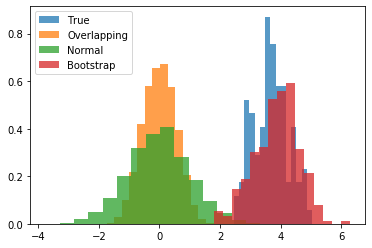

In [15]:
beta0 = 1.
beta1 = .5

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 500
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi,trials=100)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_pt(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.savefig('../figs/tobit_plot50.png')
plt.show()

In [16]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean() - np.array(bootstrap_stats).mean()
print(thing1)
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()
print(thing2)
print(thing1/thing2)

1 --------
0.0 3.6779638880500274
0.0 0.004751433877421749
0.0 -0.02596751856812857
0.0 3.8815893605342087
---------
2 --------
0.3155574713959366 0.3187449206019554
0.29630384889381123 0.2963631215181149
1.020405370202911 1.0206094921013316
0.5230824620092195 0.5248319016814926
---------
3 --------
0.008942407190740114 0.009217076057230681
-0.0008188287928081898 -0.0008193203194542573
-0.007732057452975723 -0.007736698853351673
-0.11180532309897045 -0.11293213484445187
---------
4 --------
0.24664549543873796 -0.04954904327849161
0.23424824662767224 -0.02907501597589995
3.130311957769007 0.007890863379918376
0.8635548150056123 0.049303757584524335
---------
-0.20362547248418128
0.0077389928713635925
-26.31162424734253


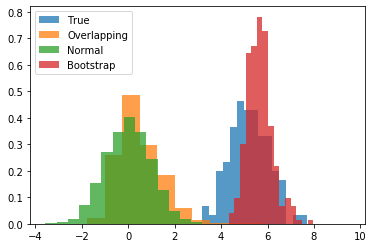

In [17]:
beta0 = 1.
beta1 = 1.

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 500
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi,trials=100)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_pt(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.savefig('../figs/tobit_plot100.png')
plt.show()

In [18]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean() - np.array(bootstrap_stats).mean()
print(thing1)
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()
print(thing2)
print(thing1/thing2)

1 --------
0.0 5.230836673772628
0.0 0.4931060969803457
0.0 -0.001704251329792322
0.0 5.662815052498341
---------
2 --------
0.7136450194861256 0.7208535550365041
0.8504785246002778 0.8506486543311441
0.9703385769763514 0.9705326835130539
0.2927074778278709 0.2936864326032161
---------
3 --------
0.09249989992825002 0.0953410636241523
0.809768971592883 0.8102550598083635
0.012132313946658396 0.012139596733530938
0.10957266229321024 0.11067697253024623
---------
4 --------
1.4604983608539808 -0.03983196219769418
4.30610285492863 2.140023988591779
2.8120604482089204 -0.01149685860679021
0.35974931939670934 0.10689715947647656
---------
-0.431978378725713
3.697123961463668
-0.11684173515098895
